In [210]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import math
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score, silhouette_samples

In [241]:
def find_best_k(X_):
    
    X_ = pd.DataFrame(MinMaxScaler().fit_transform(X_))
    ans = {'inertias': [], 'calinski_scores': [], 'davies_scores': [], 'silhouette_scores': [], 'BIC': []}
    
    for k in range(2, 10):
        model = KMeans(n_clusters=k, n_init='auto', random_state=19)
        labels = model.fit_predict(X_)
    
        inertia = model.inertia_
        calinski = calinski_harabasz_score(X_, labels)
        davies = davies_bouldin_score(X_, labels)
        silhouette = silhouette_score(X_, labels)
        bic = bic_score(X_, labels)
    
        # Append the inertia to the list of inertias
        ans['inertias'].append(inertia)
        ans['calinski_scores'].append(calinski)
        ans['davies_scores'].append(davies)
        ans['silhouette_scores'].append(silhouette)
        ans['BIC'].append(bic.max())
    
    return ans

In [276]:
def plot_best_k_scores(best_k_scores):
    fig, ax = plt.subplots(ncols=5, figsize=(20,4))

    ks = range(2, 10)
    i=0
    for key in best_k_scores:
        ax[i].plot(ks, best_k_scores[key], '-o', color='black', alpha=0.7)
        ax[i].set_xlabel("number os clusters")
        ax[i].set_title(key)
        ax[i].set_xticks(range(1,10))
    
        if key != 'inertias':
            if key != 'davies_scores':
                best_score = max(best_k_scores[key])
            else:
                best_score = min(best_k_scores[key])
    
            ax[i].axvline(x = best_k_scores[key].index(best_score) + 2, color = 'r', linestyle = '--')
    
        i += 1

In [342]:
def scatter_clusters(k_clusters, PCA_components):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
    
    labels = k_clusters.fit_predict(PCA_components)
    sample_distances = k_clusters.fit_transform(PCA_components)
    sample_silhouette_values = silhouette_samples(PCA_components, labels)
    silhouette_avg = silhouette_score(PCA_comp, labels)
    k = sample_distances.shape[1]
    
    y_lower = 10
    colors = {0: 'red', 1: 'black', 2: 'yellow'}
    for i in range(k):
        scatter = PCA_components[labels == i]
        
        ax1.scatter(scatter.loc[:,0], scatter.loc[:,1], color=cm.nipy_spectral(float(i) / 2), alpha=0.6, edgecolor='black')
        ax1.plot(k_clusters.cluster_centers_[i][0], k_clusters.cluster_centers_[i][1], 'rs')
        
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / 2)
        ax2.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        
    ax2.set_title("The silhouette plot for the various clusters.")
    ax2.set_xlabel("The silhouette coefficient values")
    ax2.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
    ax2.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax2.text(silhouette_avg + .01, .5, round(silhouette_avg, 4), color='red')

    ax2.set_yticks([])  # Clear the yaxis labels / ticks
    ax2.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()


In [339]:
def bic_score(X, labels):
    
    n_points = len(labels)
    n_clusters = len(set(labels))
    n_dimensions = X.shape[1]

    n_parameters = (n_clusters - 1) + (n_dimensions * n_clusters) + 1

    loglikelihood = 0
    for label_name in set(labels):
        X_cluster = X[labels == label_name]
        n_points_cluster = len(X_cluster)
        centroid = np.mean(X_cluster, axis=0)
        variance = np.sum((X_cluster - centroid) ** 2) / (len(X_cluster) - 1)
        loglikelihood += \
          n_points_cluster * np.log(n_points_cluster) \
          - n_points_cluster * np.log(n_points) \
          - n_points_cluster * n_dimensions / 2 * np.log(2 * math.pi * variance) \
          - (n_points_cluster - 1) / 2
    
    bic = loglikelihood - (n_parameters / 2) * np.log(n_points)
        
    return bic

In [3]:
base = pd.read_csv("../dataset/College.csv")

In [4]:
base.sample(5)

,Unnamed: 0,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
761,William Jewell College,Yes,663,547,315,32,67,1279,75,10060,2970,500,2600,74,80,11.2,19,7885,59
743,Western Michigan University,No,9167,7191,2738,24,53,15739,4278,6940,4100,500,1700,80,84,24.7,11,5983,55
30,Augustana College,Yes,761,725,306,21,58,1337,300,10990,3244,600,1021,66,70,10.4,30,6871,69
376,Mississippi University for Women,No,480,405,380,19,46,1673,1014,4386,2217,600,1500,49,54,15.8,8,5704,63
159,Davidson College,Yes,2373,956,452,77,96,1601,6,17295,5070,600,1011,95,97,12.0,46,17581,94


In [5]:
labels = base.Private.apply(lambda x: {'No': 0, 'Yes': 1}[x])
names = base['Unnamed: 0']
X_ = base.drop(columns=['Unnamed: 0', 'Private'])

In [6]:
X_.sample(5)

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
582,529,481,243,22,47,1206,134,4860,3122,600,650,103,88,17.4,16,6415,43
292,2212,1538,408,44,75,1445,1,19240,3690,750,480,95,95,11.1,46,14067,88
627,1597,969,226,16,38,1431,1522,13540,5050,630,2298,66,68,14.1,23,10139,47
561,14463,6166,1757,60,94,8544,671,6550,4598,700,1000,83,100,18.0,15,8055,80
281,2957,1423,691,10,30,3817,1394,3946,4800,400,1500,63,67,14.9,10,8367,26


In [277]:
best_k_scores = find_best_k(X_)

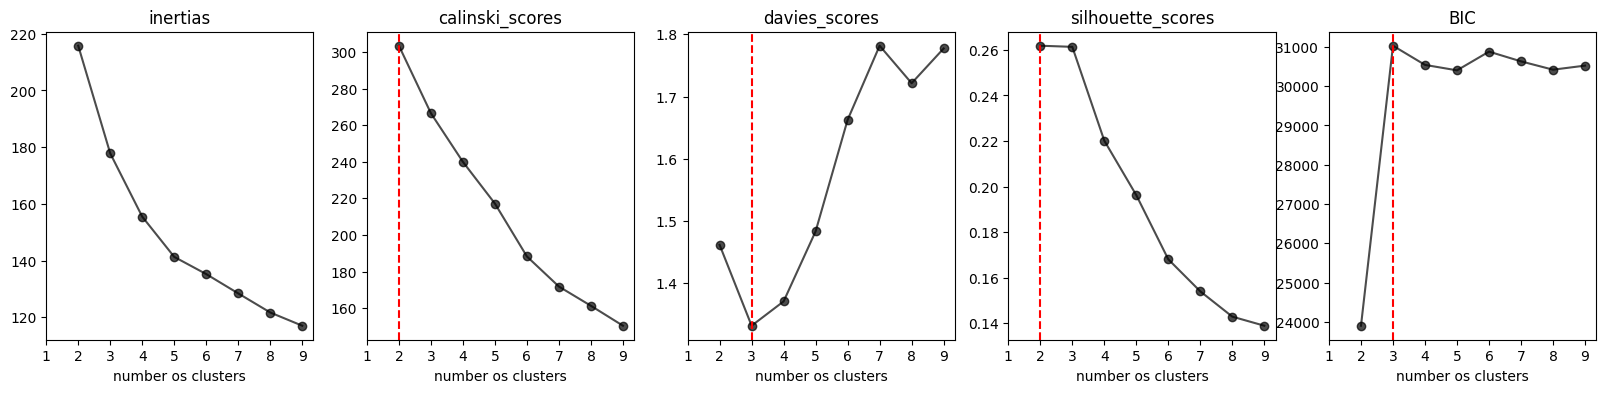

In [278]:
plot_best_k_scores(best_k_scores)

In [58]:
pca = PCA(n_components=17)

pipe = Pipeline(steps=[("scaler", MinMaxScaler()),
                       ("pca", pca)])

In [59]:
PCA_comp = pd.DataFrame(pipe.fit_transform(X_))

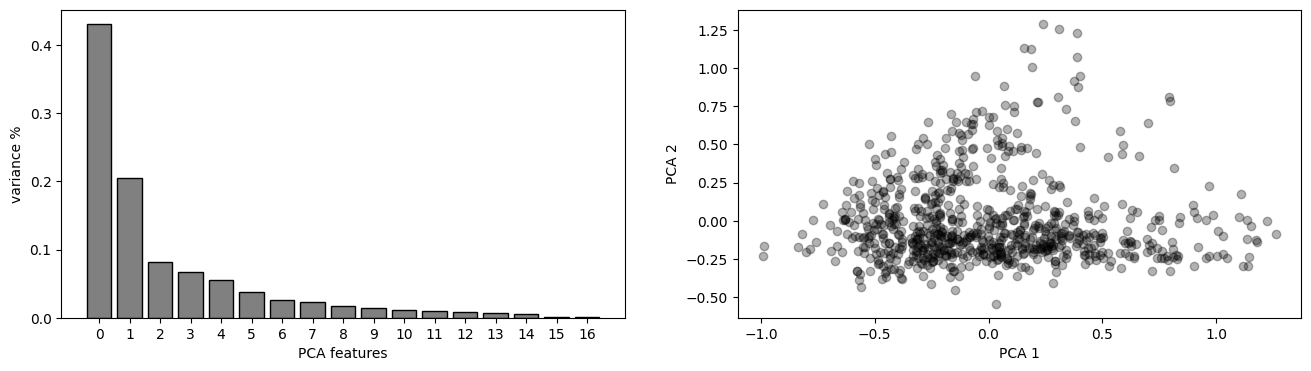

In [346]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

features = range(pca.n_components_)
ax1.bar(features, pca.explained_variance_ratio_, color='gray', edgecolor='black')
ax1.set_xlabel('PCA features')
ax1.set_ylabel('variance %')
ax1.set_xticks(features)

ax2.scatter(PCA_comp[0], PCA_comp[1], alpha=.3, color='black')
ax2.set_xlabel('PCA 1')
ax2.set_ylabel('PCA 2')

plt.show()

In [314]:
two = KMeans(n_clusters=2, n_init='auto', random_state=42)
three = KMeans(n_clusters=3, n_init='auto', random_state=42)

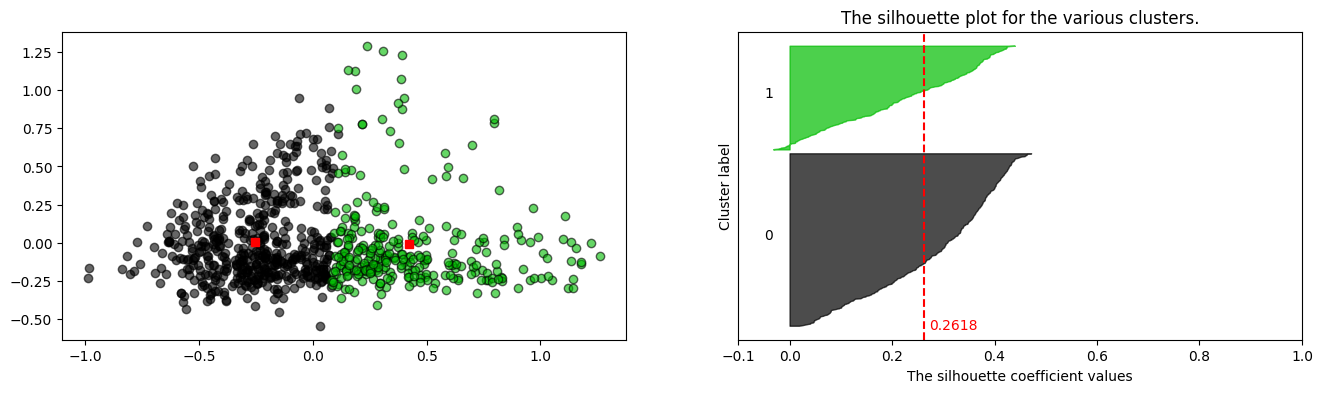

In [343]:
scatter_clusters(two, PCA_comp)

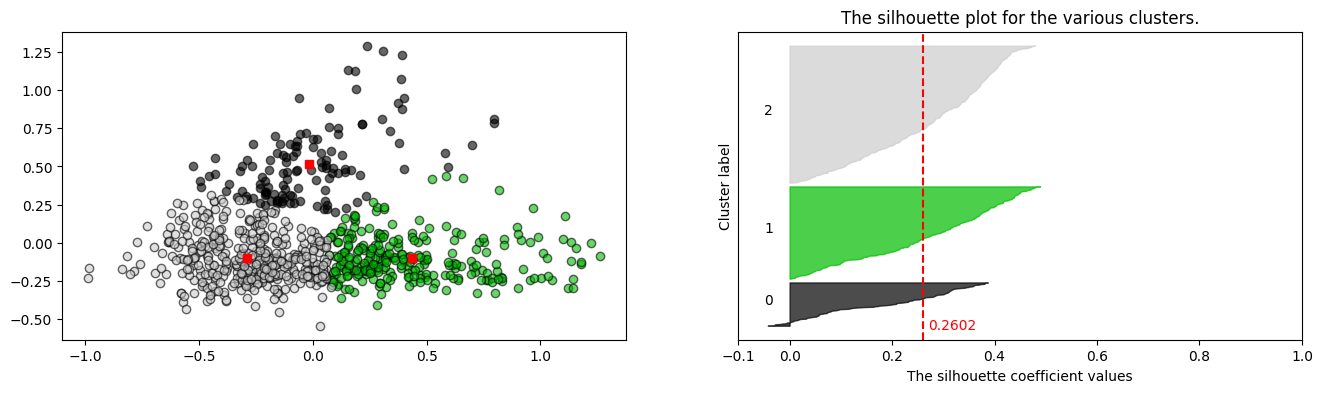

In [344]:
scatter_clusters(three, PCA_comp)